In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise,
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):

    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))

    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [5]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########

    n, m = X.shape
    # Initialize the weights
    w, w0 = Initialw(X, y)

    # Initialize variables for the convergence curve plot
    if draw_curve:
        objective_values = []

    for t in range(max_iter):
        max_update = 0.0

        for j in range(m):
            # Compute the residual without considering the j-th feature
            r_j = y - X.dot(w) - w0 + X[:, j] * w[j]

            # Compute the coordinate update for w_j
            rho_j = X[:, j].dot(r_j)
            a = X[:, j].dot(X[:, j])
            if rho_j < -lmda:
                w_j_new = (rho_j + lmda) / a
            elif rho_j > lmda:
                w_j_new = (rho_j - lmda) / a
            else:
                w_j_new = 0.0

            # Update w_j and the residual
            if w_j_new != w[j]:
                max_update = max(max_update, abs(w_j_new - w[j]))
                w[j] = w_j_new

        # Update w0
        w0 = np.mean(y - X.dot(w))

        # Compute the objective value and add it to the convergence curve
        if draw_curve:
            F = (1 / 2) * np.sum((X.dot(w) + w0 - y) ** 2) + lmda * np.sum(np.abs(w))
            objective_values.append(F)

        # Check for convergence based on the maximum weight update
        if max_update <= epsilon:
            break

    # Plot the convergence curve if required
    if draw_curve:
        plt.figure()
        plt.plot(range(t + 1), objective_values)
        plt.xlabel("Coordinate Descent Step")
        plt.ylabel("Objective Value")
        plt.title("Convergence Curve")
        plt.show()


    return (w,w0)

In [6]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

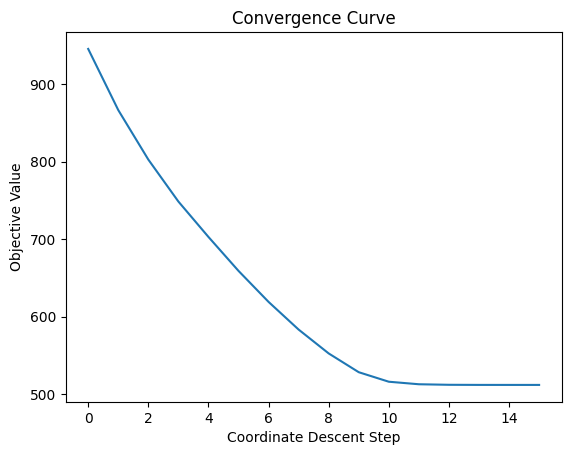

[ 9.79800275e+00 -9.68563053e+00 -9.69063070e+00  9.82989921e+00
  9.94349829e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18879339e-02
  1.52358400e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40473500e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609958e-02  0.00000000e+00
 -7.13624975e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777951e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [7]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)

In [9]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    # Calculate RMSE
    n = X.shape[0]
    rmse = np.sqrt((1 / n) * np.sum((X.dot(w) + w0 - y) ** 2))

    # Calculate sparsity (number of non-zero entries) of w
    sparsity_w = np.sum(w != 0)

    # Calculate precision and recall
    non_zero_indices_w = np.where(w != 0)[0]
    non_zero_indices_w_true = np.where(w_true != 0)[0]

    intersection = len(set(non_zero_indices_w) & set(non_zero_indices_w_true))
    precision_w = intersection / len(non_zero_indices_w) if len(non_zero_indices_w) > 0 else 0
    recall_w = intersection / len(non_zero_indices_w_true) if len(non_zero_indices_w_true) > 0 else 0

    return (rmse, sparsity_w, precision_w, recall_w)

In [10]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)

# Print the evaluation metrics
rmse, sparsity_w, precision_w, recall_w = Emetric
print("RMSE:", rmse)
print("Sparsity (number of non-zero entries in w):", sparsity_w)
print("Precision:", precision_w)
print("Recall:", recall_w)

RMSE: 0.8264628606246416
Sparsity (number of non-zero entries in w): 13
Precision: 0.38461538461538464
Recall: 1.0


In [11]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########

    n, m = X.shape
    y_bar = np.mean(y)
    lambda_max = np.max(np.abs((y - y_bar) @ X))
    lambda_min = 0.0
    Lmda = np.linspace(lambda_max, lambda_min, 50)  # 50 evenly spaced lambda values

    W = []  # To store solution paths for weights
    W0 = []  # To store solution paths for the intercept
    for lmda in Lmda:
        w, w0 = lasso(X, y, lmda=lmda)
        W.append(w)
        W0.append(w0)

    return (W, W0, Lmda)

In [12]:
from os import P_NOWAIT
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########

    RMSE = []
    Sparsity = []
    Precision = []
    Recall = []

    num_features = X.shape[1]
    colors = ['b' if abs(w_true[i]) == 10.0 else 'r' for i in range(num_features)]

    for i, lmda in enumerate(Lmda):
        w = W[i]
        w0 = W0[i]
        rmse, sparsity, precision, recall = Evaluate(X, y, w, w0, w_true, w0_true)
        RMSE.append(rmse)
        Sparsity.append(sparsity)
        Precision.append(precision)
        Recall.append(recall)

    # Plot precision and recall vs. lambda
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(Lmda, Precision, label='Precision', marker='o')
    plt.plot(Lmda, Recall, label='Recall', marker='x')
    plt.xlabel('Lambda')
    plt.ylabel('Precision/Recall')
    plt.legend()

    # Plot lasso solution paths
    plt.subplot(1, 2, 2)
    for i in range(X.shape[1]):
        plt.plot(Lmda, [w[i] for w in W], color = colors[i])
    plt.xlabel('Lambda')
    plt.ylabel('Weight (Theta_i)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return (RMSE, Sparsity, Precision, Recall)

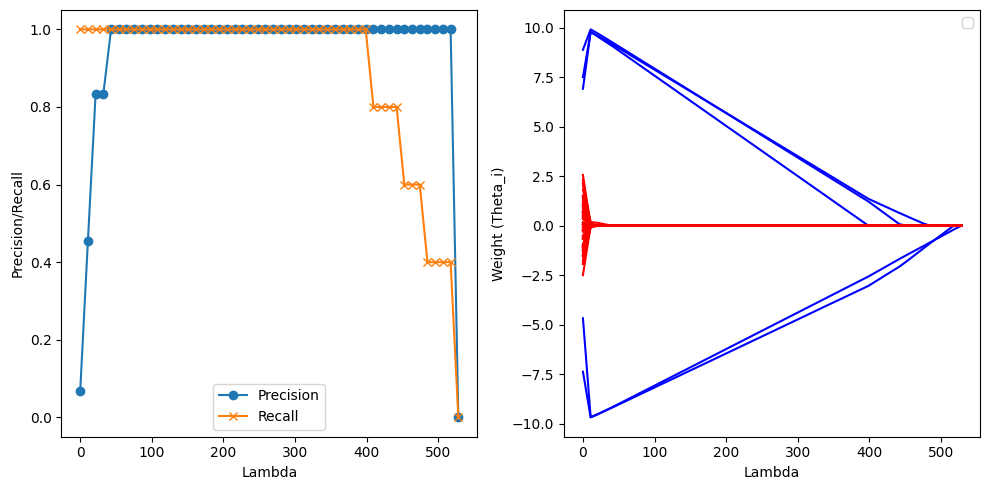

In [13]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W_path, W0_path, lambdas = LassoPath(X, y)
rmse_values, sparsity_values, precision_values, recall_values = EvaluatePath(X, y, W_path, W0_path, w_true, w0_true, lambdas)

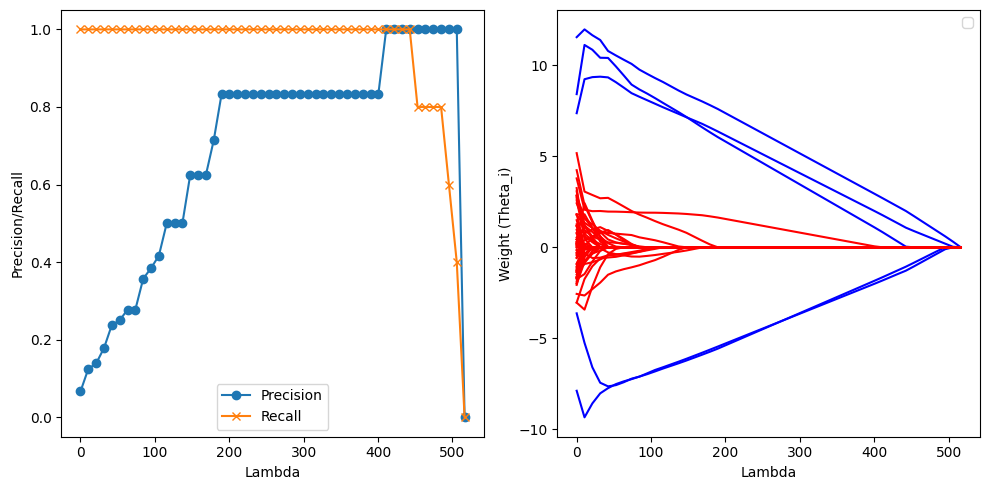

In [14]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
W_path, W0_path, lambdas = LassoPath(X, y)
rmse_values, sparsity_values, precision_values, recall_values = EvaluatePath(X, y, W_path, W0_path, w_true, w0_true, lambdas)

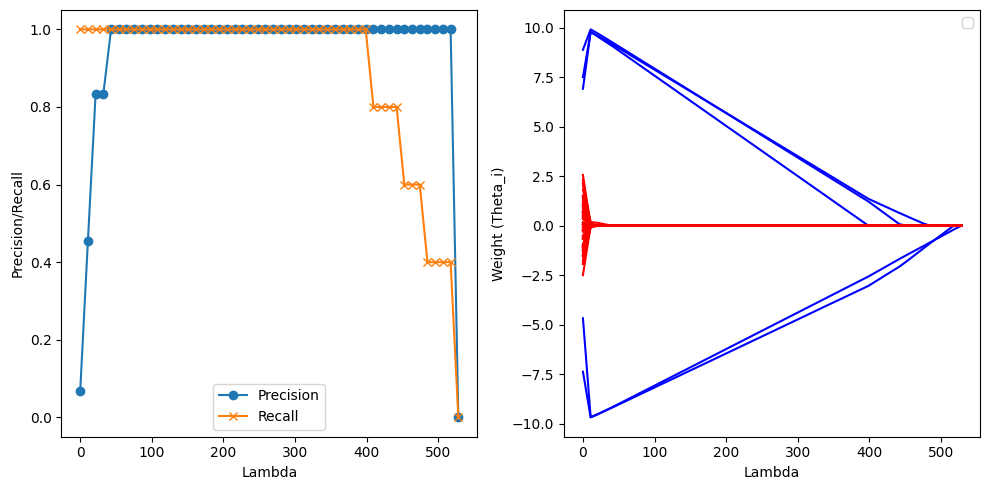

Choice of (n, m): (50, 75)
Good Lambda: 398.8878649584758


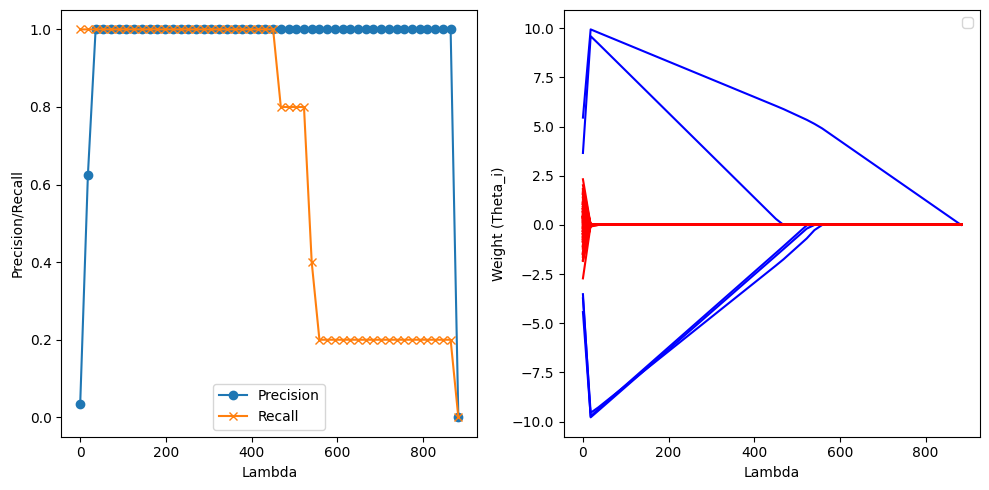

Choice of (n, m): (50, 150)
Good Lambda: 450.3936770165582


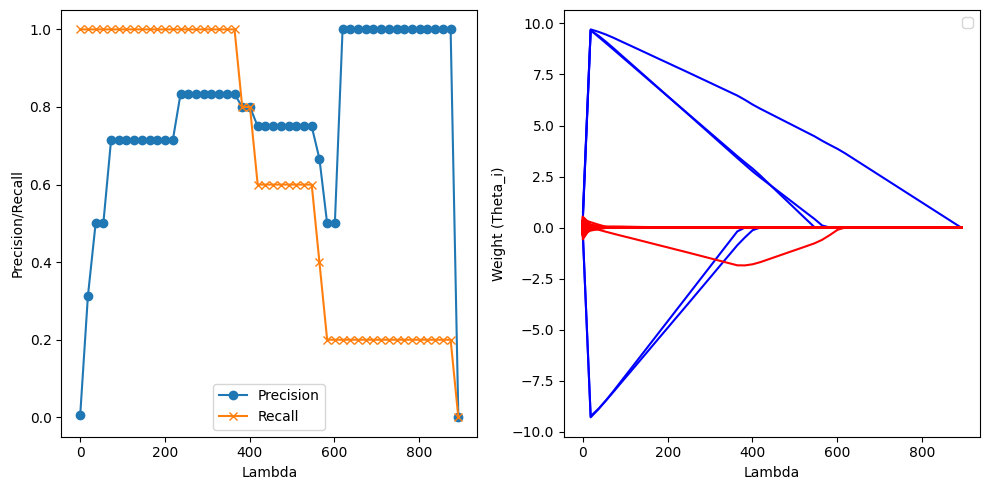

Choice of (n, m): (50, 1000)
Good Lambda: 364.45738253422644


<ipython-input-3-547bc05f37a0>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


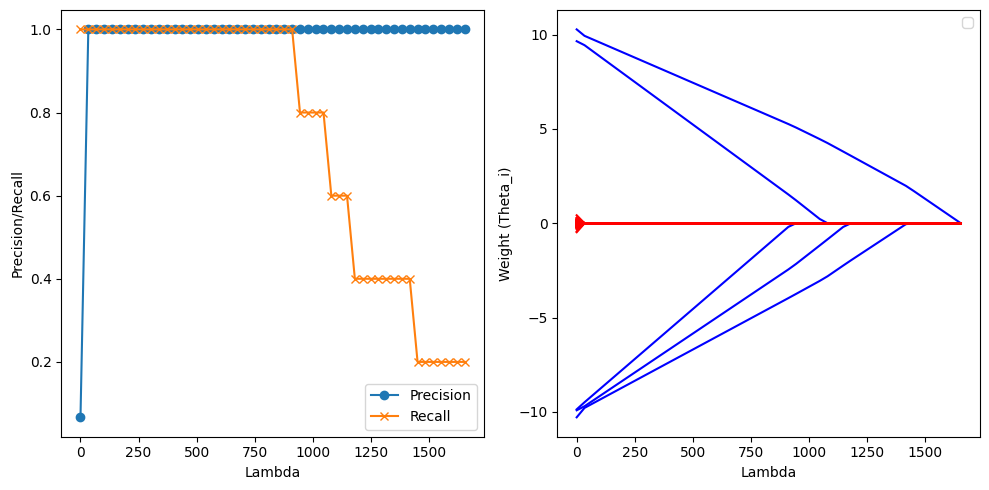

Choice of (n, m): (100, 75)
Good Lambda: 911.4028765907276


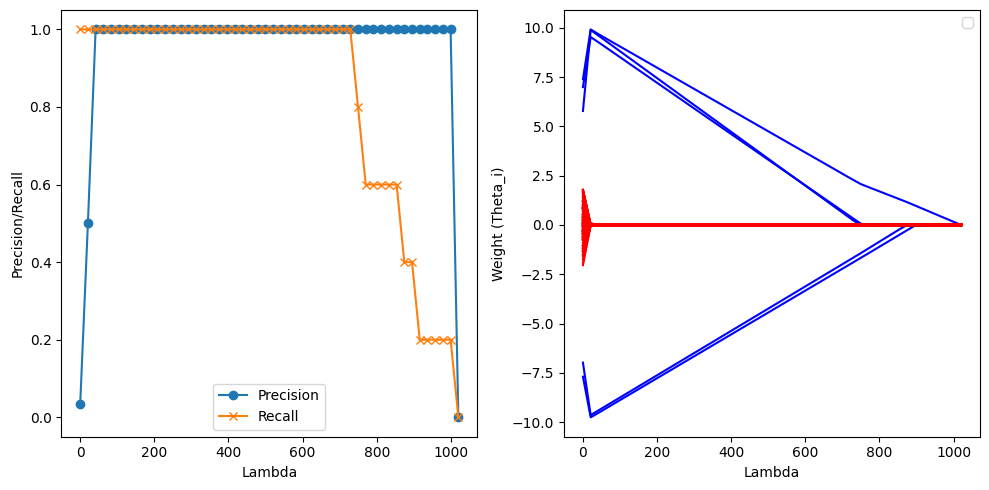

Choice of (n, m): (100, 150)
Good Lambda: 728.7075599627108


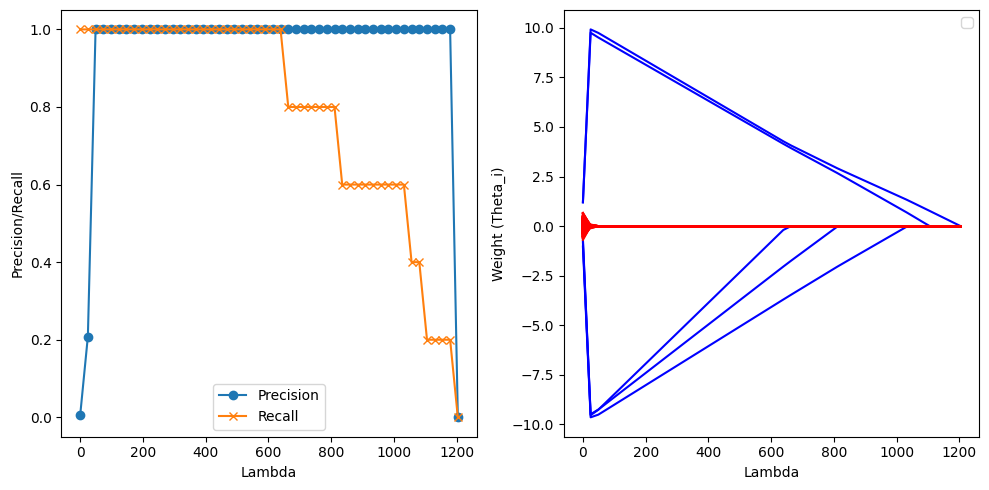

Choice of (n, m): (100, 1000)
Good Lambda: 638.7761380068198


In [15]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d)
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity

n_values = [50, 50, 50, 100, 100, 100]
m_values = [75, 150, 1000, 75, 150, 1000]

for n, m in zip(n_values, m_values):
    X, y, w_true, w0_true = DataGenerator(n=n, d=m, k=5, sigma=1.0)
    W_path, W0_path, lambdas = LassoPath(X, y)
    rmse_values, sparsity_values, precision_values, recall_values = EvaluatePath(X, y, W_path, W0_path, w_true, w0_true, lambdas)

    # Find lambda with good precision and recall
    good_lambda_index = np.argmax(np.array(precision_values) + np.array(recall_values))
    good_lambda = lambdas[good_lambda_index]

    print(f"Choice of (n, m): ({n}, {m})")
    print(f"Good Lambda: {good_lambda}")

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########

    n, m = X_train.shape

    # Calculate lambda_max and lambda_min as described
    y_bar = np.mean(y_train)
    lambda_max = np.max(np.abs((y_train - y_bar) @ X_train))
    lambda_min = 0.01 * lambda_max  # Set a small lambda_min

    # Create an array of 20 lambda values between lambda_max and lambda_min
    lambda_values = np.linspace(lambda_max, lambda_min, 20)

    training_rmse = []  # Store training RMSE
    validation_rmse = []  # Store validation RMSE

    for lmda in lambda_values:
        # Train Lasso with the current lambda value
        w_lasso, w0_lasso = lasso_sparse(X_train, y_train, lmda=lmda)

        # Make predictions on training and validation data
        y_train_pred = (X_train @ w_lasso + w0_lasso).reshape(-1, 1)
        y_valid_pred = (X_valid @ w_lasso + w0_lasso).reshape(-1, 1)

        # Calculate RMSE for training and validation
        train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
        valid_rmse = np.sqrt(np.mean((y_valid - y_valid_pred) ** 2))

        training_rmse.append(train_rmse)
        validation_rmse.append(valid_rmse)

    # Plot training RMSE vs. lambda and validation RMSE vs. lambda
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(lambda_values, training_rmse, label='Training RMSE')
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, validation_rmse, label='Validation RMSE')
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Find the best lambda with the smallest validation RMSE
    best_lambda_index = np.argmin(validation_rmse)
    lmda_best = lambda_values[best_lambda_index]

    return (w_lasso, w0_lasso, lmda_best)

(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)


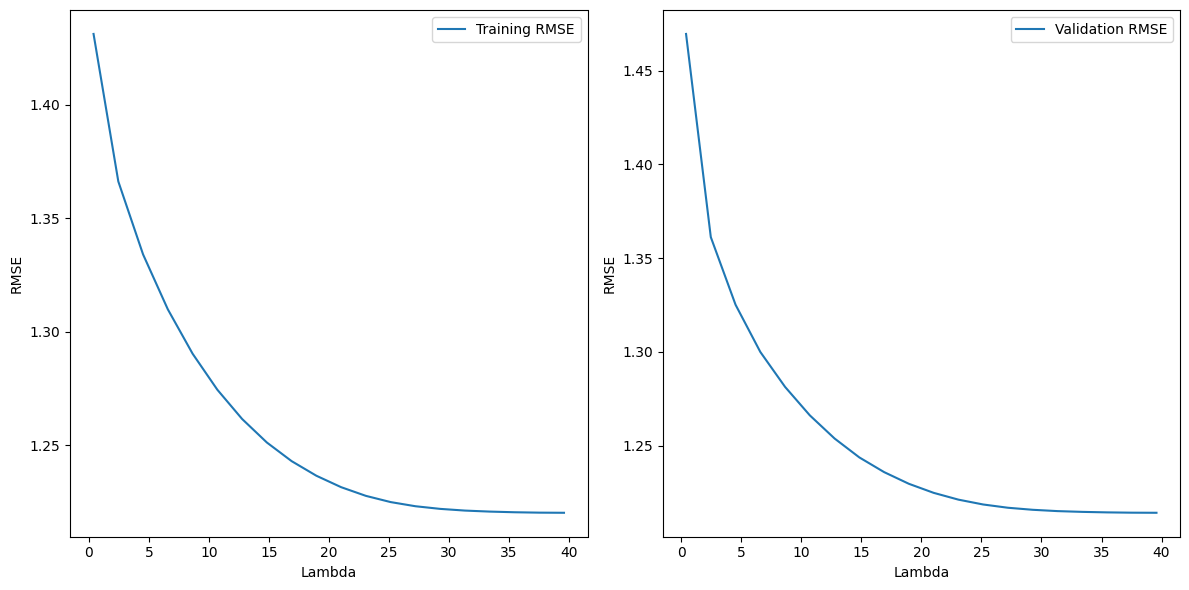

Best Lambda: 39.57825401364829
Test RMSE: 1.2660782640559964
Lasso select features:
soaked -45.511118083258644
wait to get 40.916068729915004
the marinara sauce 37.33498246625257
sometime -30.948640839729915
the -30.88807555031538
the ####s 30.134935681704913
great 22.05877800421203
was -21.252007884035123
best 19.50389650987327
not -18.93846793573279


In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

from scipy.sparse import csc_matrix

def lasso_sparse(X, y, lmda, epsilon=1.0e-2, max_iter=100):

    n, m = X.shape

    X_sparse = csc_matrix(X)
    y_sparse = csc_matrix(y.reshape(-1, 1))

    # Initialize the weights
    w, w0 = Initialw(X, y)

    for t in range(max_iter):
        max_update = 0.0

        for j in range(m):
            # Compute the residual without considering the j-th feature
            r_j = y_sparse - X_sparse.dot(w.reshape(-1, 1)) - w0 + X_sparse[:, j] * w[j]

            # Compute the coordinate update for w_j
            rho_j = X_sparse[:, j].T.dot(r_j)[0, 0]
            a = X_sparse[:, j].T.dot(X_sparse[:, j])[0, 0]
            if rho_j < -lmda:
                w_j_new = (rho_j + lmda) / a
            elif rho_j > lmda:
                w_j_new = (rho_j - lmda) / a
            else:
                w_j_new = 0.0

            # Update w_j and the residual
            if w_j_new != w[j]:
                max_update = max(max_update, abs(w_j_new - w[j]))
                w[j] = w_j_new

        # Update w0
        w0 = np.mean(y_sparse - X_sparse.dot(w.reshape(-1, 1)))

        # Check for convergence based on the maximum weight update
        if max_update <= epsilon:
            break

    return w, w0


# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('star_data.mtx', 'star_labels.txt', 'star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# Report the best lambda and corresponding test RMSE
y_test_pred = X_test @ w_lasso + w0_lasso
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f"Best Lambda: {lmda_best}")
print(f"Test RMSE: {test_rmse}")

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])